In [1]:
import pydicom
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd

In [2]:
image_df = pd.read_csv('/MRKR_dataset/MRKR_clinical_data_tables/MRKR_image_metadata.csv')
image_df = image_df.sort_values(by=['empi_anon','StudyDate_anon','StudyDescription','laterality','view_position']).reset_index(drop=True)

In [3]:
base_directory = "/MRKR_dataset_dir/"

In [4]:
image_df.dicom_path = base_directory + image_df.dicom_path

In [5]:
def apply_windowing(pixel_array, dicom_data):
    # Get WindowCenter and WindowWidth if present
    if hasattr(dicom_data, 'WindowCenter') and hasattr(dicom_data, 'WindowWidth'):
        center = dicom_data.WindowCenter
        width = dicom_data.WindowWidth

        if isinstance(center, pydicom.multival.MultiValue):
            center = center[0]
        if isinstance(width, pydicom.multival.MultiValue):
            width = width[0]

        # Apply windowing
        lower_bound = center - (width / 2)
        upper_bound = center + (width / 2)
        pixel_array = np.clip(pixel_array, lower_bound, upper_bound)

    return pixel_array


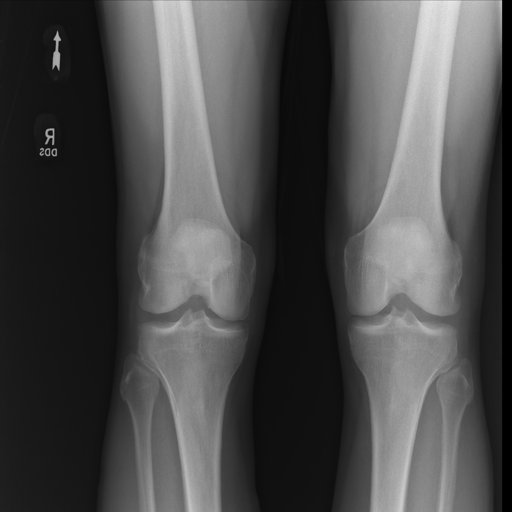

In [6]:
i = 0

#for i in tqdm(range(len(image_df))):
dicom_data = pydicom.dcmread(image_df.dicom_path[i])
pixel_array = dicom_data.pixel_array
pixel_array = apply_windowing(pixel_array, dicom_data)
pixel_array = pixel_array.astype(float)
pixel_array = pixel_array - np.min(pixel_array)
pixel_array = (pixel_array / np.max(pixel_array)) * 255.0
pixel_array = np.uint8(pixel_array)
image = Image.fromarray(pixel_array)
if image_df.inverted[i] == 1:
    image = ImageOps.invert(image)
if image_df.horizontal_flip[i] == 1:
    image = ImageOps.mirror(image)
image.resize((512,512))
#image.save(f'save_dir/{image_df.dicom_path[i].split("/",4)[-1][:-4]}.png')